In [17]:
from sklearn.utils import Bunch
from sklearn.neighbors import KNeighborsClassifier
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
from sklearn.metrics import log_loss

- import pictures
--> train_dataset
--> test_dataset

- resize pictures
--> resized

for k in range(1, 300):
    knn(k) (loss ?)( confusion matrix ?) (roc auc ?)


First thing, we have to format the dataset elements to have all the same shape, and ideally, to not be too heavy to process by the KNN model.
Therefore, we have decided that the pictures will be reformatted into squares of the same 200 * 200 dimensions.

Below, we acquire the dataset.

In [18]:
def parse_input(negatives_path, positives_path):
    images = list()
    labels = list()
    
    negative_files = os.listdir(negatives_path)
    positive_files = os.listdir(positives_path)
    total = len(negative_files) + len(positive_files)

    with tqdm(total=100) as pbar:
        for file in negative_files:
            if file.endswith('.jpeg') == False:
                continue
            images.append(cv2.imread(negatives_path + '/' + file, cv2.IMREAD_GRAYSCALE))
            labels.append(0)
            pbar.update(100/total)

        for file in positive_files:
            if file.endswith('.jpeg') == False:
                continue
            images.append(cv2.imread(positives_path + '/' + file, cv2.IMREAD_GRAYSCALE))
            labels.append(1)
            pbar.update(100/total)
    
    return images, labels


In [19]:
base_path = "./dataset"
raw_train_images, train_labels = parse_input(base_path + '/train/NORMAL', base_path + '/train/PNEUMONIA')
raw_test_images, test_labels = parse_input(base_path + '/test/NORMAL', base_path + '/test/PNEUMONIA')

100%|█████████▉| 99.99999999999713/100 [00:47<00:00,  2.09it/s]  
100%|█████████▉| 99.99999999999926/100 [00:04<00:00, 21.96it/s] 


Resizing images to 200 x 200 dimensions

In [20]:
def resize_images(images, target_dimensions):
    resized_images = np.empty((len(images), target_dimensions[0] * target_dimensions[1]))
    i = 0
    print(resized_images.shape)
    for img in tqdm(images):
        resized_images[i] = cv2.resize(img, target_dimensions).reshape((target_dimensions[0] * target_dimensions[1]))
        i += 1
    return resized_images

In [21]:
target_dimensions = (150, 150)
train_images = np.array(resize_images(raw_train_images, target_dimensions))
train_images = train_images.reshape((train_images.shape[0], 150 * 150));

test_images = np.array(resize_images(raw_test_images, target_dimensions))
test_images = test_images.reshape((test_images.shape[0], 150 * 150));

(5216, 22500)


100%|██████████| 5216/5216 [00:00<00:00, 6749.41it/s]


(624, 22500)


100%|██████████| 624/624 [00:00<00:00, 3650.77it/s]


This is the function that call the scikit-learn implementation of the KNN model. For a given value of K (and the dataset), it returns the following metrics:
- the number of nearest neighbors (k)
- the duration of the training phase
- the components of the confusion matrix (true positives, true negatives, false positives, false negatives)
- the accuracy of the model
- the logloss
- the duration of the scoring phase

In [22]:
def knn(train_images, train_labels, test_images, test_labels, k):
    start_time = time.time()
    KNN=KNeighborsClassifier(k, n_jobs=-1)
    KNN.fit(train_images, train_labels)

    result = {}
    result['training_duration'] = time.time() - start_time

    result['start_time'] = time.time()

    true_positives = 0
    true_negatives = 0
    false_positives = 0
    false_negatives = 0
    res = KNN.predict_proba(test_images)
    predictions = []

    for i in range(len(test_images)):

        prediction = np.argmax(res[i], axis=0)
        current_label = test_labels[i]
        predictions.append(res[prediction])

        if (prediction == current_label):
            if (prediction == 1):
                true_positives += 1
            else:
                true_negatives += 1
        else:
            if (prediction == 1):
                false_positives += 1
            else:
                false_negatives += 1
    
    result['predictions']=predictions
    result['true_positives']=true_positives
    result['true_negatives']=true_negatives
    result['false_positives']=false_positives
    result['false_negatives']=false_negatives
    result['logloss'] = log_loss(test_labels, predictions)
    result['accuracy'] = (true_positives + true_negatives) / len(test_images)
    result['prediction_time'] = time.time() - start_time

    return result


In previous iteration of this notebook, we have run the KNN model on this dataset with k ∈ [1, 100]. This is the accuracy curve on that interval.

![accuracy_k_1_to_100](Capture/KNN/accuracy_k_1_to_100.png)



As you may have noticed, accuracy starts decreasing from k = 1 onwards, plummeting from 0.8 to around 0.7 at k = 70. At k = 70 onwards, accuracy oscillates between 0.7 to 0.68.
Because of this, we have decided to study k ∈ [1, 100] with increments of 1 on the [1, 10] interval, and with increments of 10 onwards to k = 100.

In [23]:
ks = list()
training_durations = list()
TPs = list()
TNs = list()
FPs = list()
FNs = list()
predictions = list()
accuracies = list()
loglosses = list()
prediction_times = list()


for k in tqdm(range(1, 11)):
    knn_result = knn(train_images, train_labels, test_images, test_labels, k)
    ks.append(k)
    training_durations.append(knn_result['training_duration'])
    TPs.append(knn_result['true_positives'])
    TNs.append(knn_result['true_negatives'])
    FPs.append(knn_result['false_positives'])
    FNs.append(knn_result['false_negatives'])
    accuracies.append(knn_result['accuracy'])
    predictions.append(knn_result['predictions'])
    loglosses.append(knn_result['logloss'])
    prediction_times.append(knn_result['prediction_time'])

for k in tqdm(range(20, 101, 10)):
    knn_result = knn(train_images, train_labels, test_images, test_labels, k)
    ks.append(k)
    training_durations.append(knn_result['training_duration'])
    TPs.append(knn_result['true_positives'])
    TNs.append(knn_result['true_negatives'])
    FPs.append(knn_result['false_positives'])
    FNs.append(knn_result['false_negatives'])
    accuracies.append(knn_result['accuracy'])
    predictions.append(knn_result['predictions'])
    loglosses.append(knn_result['logloss'])
    prediction_times.append(knn_result['prediction_time'])

100%|██████████| 9/9 [00:17<00:00,  1.94s/it]


For each value of k, we measure the __prediction_time__, which is the time needed for the model to make predictions on the whole test dataset. 
The graph below shows that prediction time stays more or less the same accross the values of k, therefore prediction time is not a factor to take into account in the determination of the best value of k.

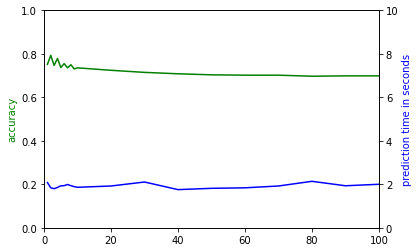

In [24]:
fig, ax = plt.subplots()
ax.plot(ks, accuracies, color='green')
ax.set_ylabel('accuracy', color='green')
ax.set_ylim(0, 1)

ax2 = ax.twinx()
ax2.set_ylim(0, 10)
ax2.plot(ks, prediction_times, color='blue')
ax2.set_ylabel('prediction time in seconds', color='blue')
plt.xlim(right=100, left=0)

plt.show()

Accuracy is far from being the whole story. We study the __confusion matrix__ metrics (__true negatives__, __true_positives__, __false_negatives__, __false_positives__) in the graphs below.

The minimum number of __false_negatives__ on the interval is 

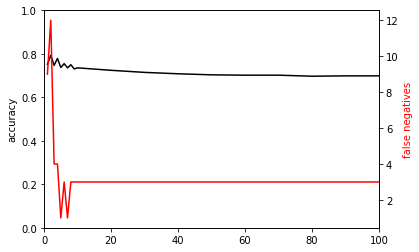

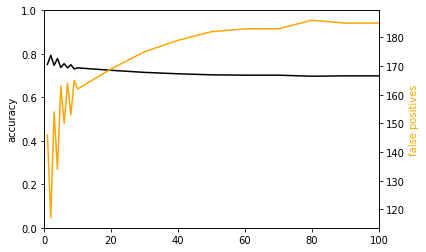

In [25]:
fig, ax = plt.subplots()

ax.plot(ks, accuracies, color='black')
ax.set_ylabel('accuracy', color='black')
ax.set_ylim(0, 1)

ax2 = ax.twinx()
ax2.plot(ks, FNs, color='red')
ax2.set_ylabel('false negatives', color='red')

plt.xlabel('k from 1 to 100')
plt.xlim(right=100, left=0)
plt.show()


fig, ax = plt.subplots()

ax.plot(ks, accuracies, color='black')
ax.set_ylabel('accuracy', color='black')
ax.set_ylim(0, 1)

ax2 = ax.twinx()
ax2.plot(ks, FPs, color='orange')
ax2.set_ylabel('false positives', color='orange')

plt.xlabel('k from 1 to 100')
plt.xlim(right=100, left=0)
plt.show()

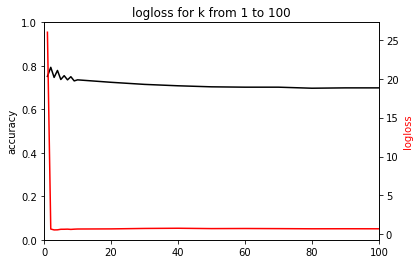

In [26]:
fig, ax = plt.subplots()

ax.plot(ks, accuracies, color='black')
ax.set_ylabel('accuracy', color='black')
ax.set_ylim(0, 1)
plt.xlim(right=100, left=0)

ax2 = ax.twinx()
ax2.plot(ks, loglosses, color='red')
ax2.set_ylabel('log loss', color='red')

plt.title('logloss for k from 1 to 100')
plt.xlabel('k from 1 to 100')
plt.ylabel('logloss')
plt.show()


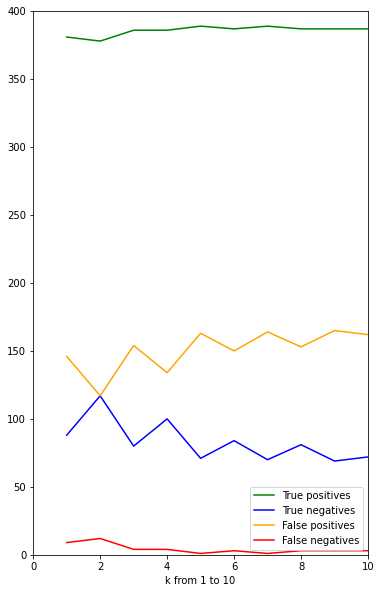

In [27]:
fig, ax = plt.subplots()
ax.plot(ks[0:10], TPs[0:10], color='green', label='True positives')
ax.plot(ks[0:10], TNs[0:10], color='blue', label='True negatives')
ax.plot(ks[0:10], FPs[0:10], color='orange', label='False positives')
ax.plot(ks[0:10], FNs[0:10], color='red', label='False negatives')
ax.legend()
ax.set_ylim(0, 400)

fig.set_size_inches(6, 10)
plt.xlabel('k from 1 to 10')
plt.xlim(right=10, left=0)
plt.show()

In [28]:
def confusion_matrix(TNs, FNs, FPs, TPs, k, accuracy):
      fig, ax = plt.subplots(1,1)
      fig.set_figheight(2)
      data=[["confusion matrix for k = " + str(k), "Actual False", "Actual True"],
            ["Predicted False",TNs,FNs],
            ["Predicted True" ,FPs,TPs]]
      colors=[['w', 'w', 'w'],["w", "green", "red"],[ "w","red", "green"]]
      ax.axis('off')
      table = ax.table(cellText=data,loc="center", cellColours=colors, colLoc='center', rowLoc='center', colWidths=[0.3, 0.2, 0.2])
      table.auto_set_font_size(False)
      table.set_fontsize(12)
      table.scale(2, 2)
      plt.title('confusion matrix for k = ' + str(k) + ' (acc ' + str(accuracy) +'%)')
      plt.show()



Here is the confusion matrix for the value of k that entails the least amount of false negatives

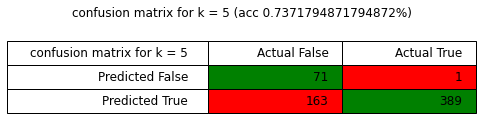

In [29]:
lowest_FN_index = FNs.index(min(FNs))
confusion_matrix(TNs[lowest_FN_index], FNs[lowest_FN_index], FPs[lowest_FN_index], TPs[lowest_FN_index],lowest_FN_index + 1, accuracies[lowest_FN_index])

And this is the confusion matrix for the value of k that entails the least amount of false positives.

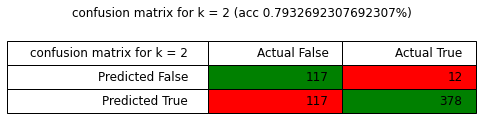

In [30]:
lowest_FPs_index = FPs.index(min(FPs))

confusion_matrix(TNs[lowest_FPs_index], FNs[lowest_FPs_index], FPs[lowest_FPs_index], TPs[lowest_FPs_index], 2, accuracies[lowest_FPs_index])